In [8]:
import json
from pathlib import Path

import pandas as pd

json_data = Path("data/2022.21-1271-t01.json")
with open(json_data) as f:
    data = json.load(f)

turns = []
for section in data["transcript"]["sections"]:
    turns.extend(section["turns"])

texts = []
for turn in turns:
    speaker_id = turn["speaker"]["identifier"]
    speaker_name = turn["speaker"]["name"]
    texts.extend([{
        "speaker_id": speaker_id,
        "speaker_name": speaker_name,
        "text": "\n".join(tb["text"] for tb in turn["text_blocks"]),
    }])

df = pd.DataFrame(texts)

df

,speaker_id,speaker_name,text
0,john_g_roberts_jr,"John G. Roberts, Jr.",We will hear argument this morning in Case 21-...
1,david_h_thompson,David H. Thompson,"Mr. Chief Justice, and may it please the Court..."
2,clarence_thomas,Clarence Thomas,"Counsel, this case is from a state supreme cou..."
3,david_h_thompson,David H. Thompson,"Yes, Your Honor.\nThank you.\nSo the Court is ..."
4,clarence_thomas,Clarence Thomas,We don't normally review state supreme courts'...
...,...,...,...
774,ketanji_brown_jackson,Ketanji Brown Jackson,So we can rule here today without adopting any...
775,elizabeth_b_prelogar,Elizabeth B. Prelogar,"Yes, we agree that it wouldn't be necessary in..."
776,john_g_roberts_jr,"John G. Roberts, Jr.","Thank you, counsel. Rebuttal, Mr. Thompson."
777,david_h_thompson,David H. Thompson,"Thank you, Mr. Chief Justice.\nJust a few quic..."


In [9]:
plain_transcript = ""
for i, row in df.iterrows():
    plain_transcript += f"{row['speaker_name']}: {row['text']}\n"

print(plain_transcript)

John G. Roberts, Jr.: We will hear argument this morning in Case 21-1271, Moore versus Harper. Mr. Thompson.
David H. Thompson: Mr. Chief Justice, and may it please the Court: The Elections Clause requires state legislatures specifically to perform the federal function of prescribing regulations for federal elections.
States lack the authority to restrict the legislatures' substantive discretion when performing this federal function. As Alexander Hamilton wrote in Federalist 78, the scope of legislative authority is governed by the commission under which it is exercised.
Here, that commission is contained in the United States Constitution, and it is federal law alone that places substantive restrictions on state legislatures performing the tasks assigned them by the federal Constitution.
The most prominent discussion of the Elections Clause in the early republic occurred during Massachusetts' 1820 Constitutional Convention. Joseph Story, then a sitting Justice on this Court, explained 

<Axes: >

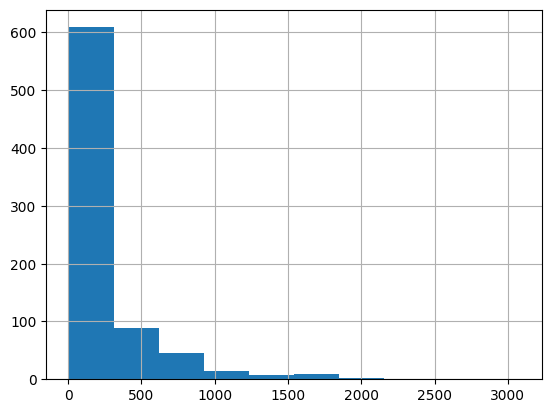

In [10]:
df["length"] = df["text"].str.len()
df["length"].hist()

In [13]:
from llama_index import GPTVectorStoreIndex, SimpleDirectoryReader, Document

documents = [Document(
    id=str(i),
    text=row["text"],
    metadata={
        "speaker_id": row["speaker_id"],
        "speaker_name": row["speaker_name"],
        "length": row["length"],
    },
) for i, row in df.iterrows()]

In [23]:
# https://gpt-index.readthedocs.io/en/latest/examples/vector_stores/postgres.html

from sqlalchemy import make_url
import psycopg2
from llama_index import SimpleDirectoryReader, StorageContext
from llama_index.indices.vector_store import VectorStoreIndex
from llama_index.vector_stores import PGVectorStore
import textwrap
import openai

pg_user = "llama"
pg_password = "llama"
db_name = "vector_db"

hybrid_vector_store = PGVectorStore.from_params(
    database=db_name,
    host="localhost",
    password=pg_password,
    port=5432,
    user=pg_user,
    table_name="sc_transcripts",
    embed_dim=1536,  # openai embedding dimension
    hybrid_search=True,
    text_search_config="english",
    perform_setup=True,
)

storage_context = StorageContext.from_defaults(
    vector_store=hybrid_vector_store
)
hybrid_index = VectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

In [24]:
hybrid_query_engine = hybrid_index.as_query_engine(
    vector_store_query_mode="hybrid", sparse_top_k=5
)

/Users/jk/Documents/dev/justice/llamaindex-pgvector-wandb/venv/lib/python3.11/site-packages/llama_index/vector_stores/postgres.py:449: SAWarning: UserDefinedType REGCONFIG() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)
  res = session.execute(stmt)


In [26]:
from llama_index import VectorStoreIndex, download_loader, ServiceContext
from llama_index.evaluation import DatasetGenerator, RelevancyEvaluator
from llama_index.callbacks import CallbackManager, WandbCallbackHandler
from llama_index.llms import OpenAI

import copy
from dotenv import load_dotenv
import os
from pathlib import Path
import random
import textwrap as tr

# This is a hack to get some things to work in Jupyter Notebooks
import nest_asyncio
nest_asyncio.apply()

def pwrap(text):
    print(tr.fill(str(text), width=80))

In [27]:
# generate some questions

random_documents = [doc.copy(deep=True) for doc in documents]
random.shuffle(random_documents)
random_documents = random_documents[:20]

llm = OpenAI(temperature=0, model="gpt-3.5-turbo")

service_context = ServiceContext.from_defaults(llm=llm)

# Let's reduce the number of questions per chunk.
data_generator = DatasetGenerator.from_documents(
    random_documents, service_context=service_context, num_questions_per_chunk=2
)

eval_questions = data_generator.generate_questions_from_nodes()

In [28]:
eval_questions

["How does Mr. Thompson's statement reflect his willingness to allow someone to speak?",
 'In what role is Mr. Kavanaugh addressing Mr. Thompson and what does this suggest about their relationship?',
 'How does the concept of a "flunked standard" relate to the role of a teacher or professor in evaluating student performance?',
 'In what ways might a standard be considered "flunked" in the context of education and assessment?',
 'According to Mr. Alito, why is it inevitable that state courts will have to interpret statutes enacted by the legislature to govern elections?',
 'In what ways are state election officials in the Executive Branch expected to make decisions regarding the conduct of elections, as mentioned by Mr. Alito?',
 "How does Justice Gorsuch's presence or involvement impact the current situation or discussion?",
 "What is the significance of Justice Gorsuch's perspective or viewpoint in the given context?",
 "How does the speaker's role as Donald B. Verrilli, Jr. relate to

In [36]:
# Evaluate all the question/answer pairs
from llama_index.evaluation import (
    FaithfulnessEvaluator,
    RelevancyEvaluator,
    CorrectnessEvaluator,
)
gpt4 = OpenAI(temperature=0, model="gpt-4")

service_context_gpt4 = ServiceContext.from_defaults(llm=gpt4)

faithfulness_gpt4 = FaithfulnessEvaluator(service_context=service_context_gpt4)
relevancy_gpt4 = RelevancyEvaluator(service_context=service_context_gpt4)
correctness_gpt4 = CorrectnessEvaluator(service_context=service_context_gpt4)


from llama_index.evaluation import BatchEvalRunner

runner = BatchEvalRunner(
    {"relevancy": relevancy_gpt4},
    workers=1,
)

eval_results = await runner.aevaluate_queries(
    hybrid_query_engine, queries=eval_questions[:100]
)

sys:1: SAWarning: UserDefinedType REGCONFIG() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)


In [37]:
def get_eval_results(key, eval_results):
    results = eval_results[key]
    correct = 0
    for result in results:
        if result.passing:
            correct += 1
    score = correct / len(results)
    print(f"{key} Score: {score}")
    return score

# fscore = get_eval_results("faithfulness", eval_results)
rscore = get_eval_results("relevancy", eval_results)

relevancy Score: 0.675


In [42]:
len(plain_transcript)

188175

In [47]:
import tiktoken

def count_tokens(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    num_tokens = len(encoding.encode(string))
    return num_tokens

count_tokens(plain_transcript)

41482

In [63]:
from llama_index.node_parser import SentenceWindowNodeParser, SimpleNodeParser

node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=5,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)
sentence_nodes = node_parser.get_nodes_from_documents(documents)
sentence_index = VectorStoreIndex(sentence_nodes)

In [64]:
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor

query_engine = sentence_index.as_query_engine(
    similarity_top_k=2,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ],
)
window_response = query_engine.query(
    "What are the concerns surrounding the AMOC?"
)
print(window_response)

The concerns surrounding the AMOC are related to potential separation-of-powers issues between the state legislature and the state courts.


In [51]:
hybrid_query_engine_windowed = sentence_index.as_query_engine(
    vector_store_query_mode="hybrid", sparse_top_k=5,
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ],
)

eval_results_windowed = await runner.aevaluate_queries(
    hybrid_query_engine_windowed, queries=eval_questions[:100]
)

sys:1: SAWarning: UserDefinedType REGCONFIG() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)
sys:1: SAWarning: UserDefinedType REGCONFIG() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)


In [68]:
eval_results_windowed = await runner.aevaluate_queries(
    query_engine, queries=eval_questions[:100]
)

In [69]:
rscore2 = get_eval_results("relevancy", eval_results_windowed)

relevancy Score: 0.7


In [75]:
window_response = query_engine.query(
    eval_questions[2]
)
window = window_response.source_nodes[1].node.metadata["window"]
sentence = window_response.source_nodes[1].node.metadata["original_text"]

print(f"Window: {window}")
print("------------------")
print(f"Original Sentence: {sentence}")

Window: Is your standard a standard that can be flunked?
------------------
Original Sentence: Is your standard a standard that can be flunked?


In [82]:
from llama_index import download_loader

StringIterableReader = download_loader("StringIterableReader")

loader = StringIterableReader()
documents = loader.load_data(texts=[plain_transcript])

node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=7,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)
sentence_nodes = node_parser.get_nodes_from_documents(documents)
sentence_index = VectorStoreIndex(sentence_nodes)

In [83]:
query_engine = sentence_index.as_query_engine(
    similarity_top_k=2,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ],
)

window_response = query_engine.query(
    eval_questions[2]
)
window = window_response.source_nodes[1].node.metadata["window"]
sentence = window_response.source_nodes[1].node.metadata["original_text"]

print(f"Window: {window}")
print("------------------")
print(f"Original Sentence: {sentence}")

Window: Justice Thomas?  Justice Alito?
 Samuel A. Alito, Jr. : Is your standard a standard that can be flunked?
 Donald B. Verrilli, Jr. : Yeah, I assume it could be flunked.
 Samuel A. Alito, Jr. : Give me an example of something that would flunk your standard.
 Donald B. Verrilli, Jr. : So, you know, I think a naked declaration that a -- that an act of a legislature under a free and fair elections clause is unfair, without any grounding in history or precedent or -- or sound analysis of a kind that the state -- that the state, you know, is appropriate under that state's mode of interpretation, I -- I think -- I think you could envision that possibility happening.
 Samuel A. Alito, Jr. : Okay.
 Donald B. Verrilli, Jr. : I do think that would be a rare case, but I think --
Samuel A. Alito, Jr.
------------------
Original Sentence: : Give me an example of something that would flunk your standard.



In [79]:
eval_results_windowed_long = await runner.aevaluate_queries(
    query_engine, queries=eval_questions[:100]
)

In [80]:
rscore2 = get_eval_results("relevancy", eval_results_windowed)

relevancy Score: 0.7


In [84]:
from llama_index.query_engine import RetrieverQueryEngine

node_parser = SimpleNodeParser.from_defaults(chunk_size=1024)
base_nodes = node_parser.get_nodes_from_documents(documents)
for idx, node in enumerate(base_nodes):
    node.id_ = f"node-{idx}"

base_index = VectorStoreIndex(base_nodes)
base_retriever = base_index.as_retriever(similarity_top_k=2)

query_engine_base = RetrieverQueryEngine.from_args(
    base_retriever, service_context=service_context
)

Mr. Kavanaugh is addressing Mr. Thompson in a questioning role. This suggests that they are engaged in a legal debate or argument, where Mr. Kavanaugh is seeking clarification or challenging Mr. Thompson's position. Their relationship appears to be adversarial, as they are presenting opposing viewpoints and engaging in a back-and-forth exchange.


In [85]:
response = query_engine_base.query(
    eval_questions[1]
)
print(eval_questions[1], str(response))

In what role is Mr. Kavanaugh addressing Mr. Thompson and what does this suggest about their relationship? Mr. Kavanaugh is addressing Mr. Thompson in a questioning role. This suggests that they are engaged in a legal debate or argument, where Mr. Kavanaugh is seeking clarification or challenging Mr. Thompson's position. Their relationship appears to be adversarial, as they are presenting opposing viewpoints and engaging in a back-and-forth exchange.


In [90]:
# evaluate query_engine_base

eval_results_base = await runner.aevaluate_queries(
    query_engine_base, queries=eval_questions[:100]
)

rscore_base = get_eval_results("relevancy", eval_results_base)

In [86]:
from llama_index.schema import IndexNode


sub_chunk_sizes = [128, 256, 512]
sub_node_parsers = [
    SimpleNodeParser.from_defaults(chunk_size=c) for c in sub_chunk_sizes
]

all_nodes = []
for base_node in base_nodes:
    for n in sub_node_parsers:
        sub_nodes = n.get_nodes_from_documents([base_node])
        sub_inodes = [
            IndexNode.from_text_node(sn, base_node.node_id) for sn in sub_nodes
        ]
        all_nodes.extend(sub_inodes)

    # also add original node to node
    original_node = IndexNode.from_text_node(base_node, base_node.node_id)
    all_nodes.append(original_node)
all_nodes_dict = {n.node_id: n for n in all_nodes}

In [87]:
vector_index_chunk = VectorStoreIndex(
    all_nodes
)

In [88]:
from llama_index.retrievers import RecursiveRetriever

vector_retriever_chunk = vector_index_chunk.as_retriever(similarity_top_k=2)
retriever_chunk = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk},
    node_dict=all_nodes_dict,
    verbose=True,
)

In [89]:
query_engine_chunk = RetrieverQueryEngine.from_args(
    retriever_chunk, service_context=service_context
)
response = query_engine_chunk.query(
    eval_questions[1]
)
print(eval_questions[1], str(response))

Retrieving with query id None: In what role is Mr. Kavanaugh addressing Mr. Thompson and what does this suggest about their relationship?
Retrieved node with id, entering: node-7
Retrieving with query id node-7: In what role is Mr. Kavanaugh addressing Mr. Thompson and what does this suggest about their relationship?
In what role is Mr. Kavanaugh addressing Mr. Thompson and what does this suggest about their relationship? Mr. Kavanaugh is addressing Mr. Thompson in a conversational manner, suggesting that they have a professional relationship and are engaged in a discussion or debate.


In [ ]:
# evaluate query_engine_chunk

eval_results_chunk = await runner.aevaluate_queries(
    query_engine_chunk, queries=eval_questions[:100]
)

rscore_chunk = get_eval_results("relevancy", eval_results_chunk)